In [1]:
from reactionmodel.model import Species, Reaction, Model
import numpy as np
from numba import jit

X = Species('X')

@jit(nopython=True)
def k(t):
    return np.array([t/30])

r = Reaction([X], [], k=k)

m = Model([X], [r])

In [2]:
import hybrid.parse as parse

sf = parse.PreconfiguredSimulatorLoader.load_preconfigured('hr_original')
simulator = sf.make_simulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

In [3]:
x0 = 10000
t_span = (0.0, 5.0)
t = np.linspace(min(t_span), max(t_span), 51)
result = simulator.simulate(t_span, [x0], rng=np.random.default_rng(), t_eval=t)
result.status_counter

Counter({<HybridStepStatus.contrived_no_reaction: 4>: 64,
         <HybridStepStatus.t_end: 0>: 1})

[]

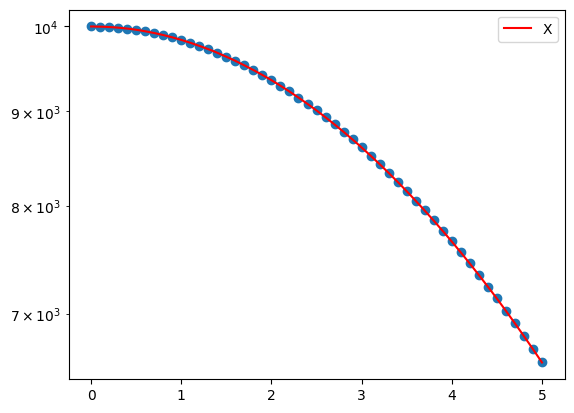

In [4]:
import matplotlib.pyplot as plt
ax = plt.subplot()

result.plot(m.legend(), ax=ax, c='r')
y = x0*np.exp(-1/60 * t**2)
ax.scatter(t, y)
ax.semilogy()

# Implicit tau leaping

In [5]:
from hybrid.tau import TauLeapSimulator

ts = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    method='implicit',
    time_handling='inhomogeneous',
    epsilon=0.01
)

In [6]:
ts.time_handling

<TimeHandling.inhomogeneous: 'inhomogeneous'>

In [7]:
result = ts.simulate(t_span, [x0], rng=np.random.default_rng(), t_eval=t)
result.status_counter

/Users/thayer/develop/hybrid/hybrid/tau.py:306: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  print(tau, tau_prime, self.rejection_multiple/np.sum(propensities))
/Users/thayer/develop/hybrid/hybrid/tau.py:438: RuntimeWarning: divide by zero encountered in scalar divide
  if tau_prime < self.rejection_multiple / total_propensity:


inf 0 inf
0.17993282257646814 0.004168244450432711 0.036350065166963264
0.12871695351506743 0.005826769179965996 0.02626876602348315
0.10564947044104686 0.007099638856223503 0.021783395967226157
0.09141459041739261 0.008204405601035457 0.019044706336956794
0.08229017005323741 0.00911710931582319 0.01732424632699735
0.07617681565550281 0.009846202301795016 0.01620783311819209
0.06983856815204585 0.010739135657551916 0.015019046914418462
0.06548540306360205 0.011452945943612057 0.014235957187739576
0.06223188991089353 0.012056452324951053 0.013677338441954623
0.05881159587870219 0.012754014982372964 0.013069243528600488
0.055975956424801146 0.013399008039373193 0.012578866612314863
0.05569746084388426 0.013465950016737085 0.012527544049456649
0.05542035198138524 0.013533232911072526 0.01249613347945552
0.05514462278999137 0.01360085781853702 0.012447996115122203
0.05487026627373969 0.013668825880025834 0.012395858189029638
0.05459727548641783 0.013737138290592895 0.012348134227392926
0.0

/Users/thayer/develop/hybrid/hybrid/tau.py:407: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_end = fsolve(objective_function, y)


Counter({<TauStepStatus.stochastic: 4>: 1103,
         <TauStepStatus.leap: 2>: 125,
         <TauStepStatus.rejected_for_gillespie: -2>: 12,
         <TauStepStatus.t_end: 0>: 1})

[]

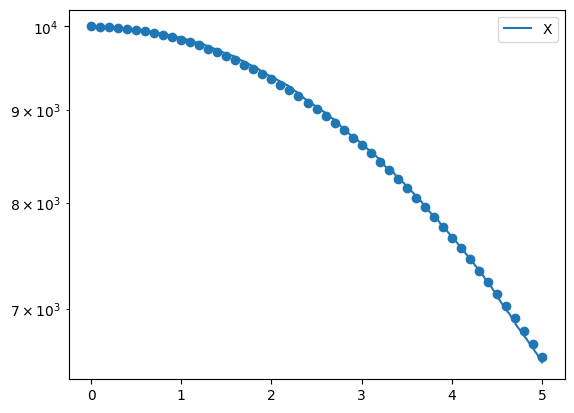

In [9]:
import matplotlib.pyplot as plt
ax = plt.subplot()

result.plot(m.legend(), ax=ax)
y = x0*np.exp(-1/60 * t**2)
ax.scatter(t, y)
ax.semilogy()